In [1]:
#-*- coding:utf-8 -*-
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.utils.data as data

# train = pd.read_csv("data.csv",parse_dates=["Date"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wind1 = pd.read_csv("./dataset/wind1.csv")
wind2 = pd.read_csv("./dataset/wind2.csv")
wind3 = pd.read_csv("./dataset/wind3.csv")
wind4 = pd.read_csv("./dataset/wind4.csv")

In [2]:
from torch.optim.lr_scheduler import ExponentialLR

# Hyper-Parameters
sequence_length = 36
input_size = 2
hidden_size = 64
num_layers = 3
output_size = 4
batch_size = 64
num_epochs = 32
learning_rate = 1e-2

In [3]:
class mydata(data.Dataset):
    def __init__(self, input_dat, y,seq_length):
        self.input_dat = torch.tensor(input_dat).float()
        self.y = torch.tensor(y).float()
        self.seq_length = seq_length

    def __getitem__(self, idx):
        if idx >= self.seq_length - 1:
            i_start = idx - self.seq_length + 1
            x = self.input_dat[i_start:(idx-3),:]
            y = self.y[(idx-3):(idx+1)]
        elif idx>=3:
            padding = self.input_dat[0].repeat(self.seq_length-idx-1,1)
            x = self.input_dat[0:(idx-3),:]
            x = torch.cat((padding,x),0)
            y = self.y[(idx-3):(idx+1)]
        else:
            x = self.input_dat[0].repeat(self.seq_length-4,1)
            padding_y = self.y[0].repeat(3-idx)
            y = self.y[0:(idx+1)]
            y = torch.cat((padding_y,y),0)
        return x, y
    
    def __len__(self):
        return self.input_dat.shape[0]

Using two strategies,

1. Test using MA data and Test relative error using MA data
2. Test using original data and test re using original data

Later, I'll figure out how to test using original data

Split the 4th dataset to test set and the first 3 dataset as training set.

In [4]:
# Training Sets
train1 = np.array(wind1[["GridPowerMA","WindSpdMA"]][19:])
train_data1 = mydata(train1, train1[:,1], sequence_length)
train2 = np.array(wind2[["GridPowerMA","WindSpdMA"]][19:])
train_data2 = mydata(train2, train2[:,1], sequence_length)
train3 = np.array(wind3[["GridPowerMA","WindSpdMA"]][19:])
train_data3 = mydata(train3, train3[:,1], sequence_length)

# Test Sets
test = np.array(wind4[["GridPowerMA","WindSpdMA"]][19:])
test_target = np.array(wind4["GridPower"][19:])
test_data = mydata(test, test_target, sequence_length)
test_data1 = mydata(test,test[:,1],sequence_length)

# Data Loader
train_dat1 = data.DataLoader(dataset=train_data1, batch_size=batch_size, shuffle=True)
train_dat2 = data.DataLoader(dataset=train_data2, batch_size=batch_size, shuffle=True)
train_dat3 = data.DataLoader(dataset=train_data3, batch_size=batch_size, shuffle=True)
test_dat = data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
test_dat1 = data.DataLoader(dataset=test_data1, batch_size=batch_size, shuffle=True)

In [5]:
##Build RNN(LSTM)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self, x):
        # set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

lstm_ma = RNN(input_size, hidden_size, num_layers, output_size).to(device)
lstm_o = RNN(input_size,hidden_size, num_layers, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
op_ma = torch.optim.Adam(lstm_ma.parameters(), lr=learning_rate)
op_o = torch.optim.Adam(lstm_ma.parameters(), lr=learning_rate)
scheduler_ma = ExponentialLR(op_ma,gamma=0.9)
scheduler_o = ExponentialLR(op_o,gamma=0.9)

In [6]:
# Training
for epoch in range(num_epochs):
    for i, (value,labels) in enumerate(train_dat1):
        value = value.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = lstm_ma(value)
        loss = criterion(outputs.squeeze(),labels.squeeze())

        # optimization step
        op_ma.zero_grad()
        loss.backward()
        op_ma.step()

        if i % 500 == 0:
            print(loss.item())
    
    for i, (value,labels) in enumerate(train_dat2):
        value = value.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = lstm_ma(value)
        loss = criterion(outputs.squeeze(),labels.squeeze())

        # optimization step
        op_ma.zero_grad()
        loss.backward()
        op_ma.step()

        if i % 500 == 0:
            print(loss.item())
    
    for i, (value,labels) in enumerate(train_dat3):
        value = value.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = lstm_ma(value)
        loss = criterion(outputs.squeeze(),labels.squeeze())

        # optimization step
        op_ma.zero_grad()
        loss.backward()
        op_ma.step()

        if i % 500 == 0:
            print(loss.item())
    
    scheduler_ma.step()

0.19760975241661072
0.14744465053081512
0.0993977040052414
0.22255094349384308
0.14501284062862396
0.0961771234869957
0.17409969866275787
0.13885492086410522
0.09579665958881378
0.15720975399017334
0.1523239016532898
0.09157093614339828
0.1849571168422699
0.13690832257270813
0.08965133875608444
0.1625521034002304
0.13476505875587463
0.08916685730218887
0.18404506146907806
0.12919175624847412
0.08475460112094879
0.20138932764530182
0.12655647099018097
0.08530554175376892
0.1872718334197998
0.13152457773685455
0.08149731904268265
0.16496926546096802
0.1344364583492279
0.08243528008460999
0.1849166601896286
0.11921854317188263
0.08010490238666534
0.1592596173286438
0.1376819759607315
0.07920050621032715
0.1913996934890747
0.11749733239412308
0.07862091809511185
0.19278787076473236
0.11667370051145554
0.07776272296905518
0.17679521441459656
0.11957874149084091
0.07778643816709518
0.19156214594841003
0.11739461869001389
0.07683396339416504
0.1587657630443573
0.12257460504770279
0.0740866065

In [7]:
# Evaluation
lstm_ma.eval()
mse = 0
i = 0
re = np.array([])
with torch.no_grad():
    for values, labels in test_dat:
        values = values.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        outputs = lstm_ma(values)
        mse += torch.sum((outputs-labels)**2)
        i += len(labels.flatten())
        re_tmp = np.array(np.abs(labels.flatten()-outputs.flatten()))
        re = np.concatenate((re,re_tmp),axis=0)
print(mse/i)
# mean_rerror = np.mean(re)
# max_rerror = np.max(re)
# median_rerror = np.median(re)
# print(mean_rerror)
# print(max_rerror)
# print(median_rerror)
idx = re <= 0.15
idx = idx + 0
print(sum(idx)/len(idx))

tensor(0.1594)
0.2977318888252372
1.0506479740142822
0.21406804025173187
0.3798245614035088


In [8]:
# Evaluation using ma data
lstm_ma.eval()
mse = 0
i = 0
re = np.array([])
with torch.no_grad():
    for values, labels in test_dat1:
        values = values.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        outputs = lstm_ma(values)
        mse += torch.sum((outputs-labels)**2)
        i += len(labels.flatten())
        re_tmp = np.array(np.abs(labels.flatten()-outputs.flatten()))
        re = np.concatenate((re,re_tmp),axis=0)
print(mse/i)
# mean_rerror = np.mean(re)
# max_rerror = np.max(re)
# median_rerror = np.median(re)
# print(mean_rerror)
# print(max_rerror)
# print(median_rerror)
idx = re <= 0.15
idx = idx + 0
print(sum(idx)/len(idx))

tensor(0.1181)
0.31916616536154035
0.6387339234352112
0.31892967224121094
0.10438596491228071


If just input the original data, let's see what will happen.

In [5]:
# Training Sets
train1 = np.array(wind1[["GridPower","WindSpd"]][19:])
train_data1 = mydata(train1, train1[:,1], sequence_length)
train2 = np.array(wind2[["GridPower","WindSpd"]][19:])
train_data2 = mydata(train2, train2[:,1], sequence_length)
train3 = np.array(wind3[["GridPower","WindSpd"]][19:])
train_data3 = mydata(train3, train3[:,1], sequence_length)

# Data Loader
train_dat1 = data.DataLoader(dataset=train_data1, batch_size=batch_size, shuffle=True)
train_dat2 = data.DataLoader(dataset=train_data2, batch_size=batch_size, shuffle=True)
train_dat3 = data.DataLoader(dataset=train_data3, batch_size=batch_size, shuffle=True)
test_dat = data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
test_dat1 = data.DataLoader(dataset=test_data1, batch_size=batch_size, shuffle=True)

In [10]:
# Training
for epoch in range(num_epochs):
    for i, (value,labels) in enumerate(train_dat1):
        value = value.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = lstm_o(value)
        loss = criterion(outputs.squeeze(),labels.squeeze())

        # optimization step
        op_o.zero_grad()
        loss.backward()
        op_o.step()

        if i % 500 == 0:
            print(loss.item())
    
    for i, (value,labels) in enumerate(train_dat2):
        value = value.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = lstm_o(value)
        loss = criterion(outputs.squeeze(),labels.squeeze())

        # optimization step
        op_o.zero_grad()
        loss.backward()
        op_o.step()

        if i % 500 == 0:
            print(loss.item())
    
    for i, (value,labels) in enumerate(train_dat3):
        value = value.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = lstm_ma(value)
        loss = criterion(outputs.squeeze(),labels.squeeze())

        # optimization step
        op_o.zero_grad()
        loss.backward()
        op_o.step()

        if i % 500 == 0:
            print(loss.item())
    
    scheduler_o.step()

0.14478901028633118
0.11397887021303177
0.07248613238334656
0.1501542627811432
0.11531955003738403
0.0728921890258789
0.1651328057050705
0.10285234451293945
0.07143295556306839
0.16502080857753754
0.12053820490837097
0.06961232423782349
0.15188097953796387
0.11999977380037308
0.07065217196941376
0.15454572439193726
0.12193542718887329
0.0696645975112915
0.17325231432914734
0.1269012689590454
0.06745875626802444
0.16250915825366974
0.120297372341156
0.06943895667791367
0.17391438782215118
0.1185268759727478
0.06932874023914337
0.15296819806098938
0.1245272234082222
0.06785570085048676
0.17864647507667542
0.11547940969467163
0.06775322556495667
0.14583159983158112
0.11393821239471436
0.06830829381942749
0.1509452760219574
0.10806100070476532
0.06637399643659592
0.14816230535507202
0.11335279047489166
0.06855303794145584
0.15407656133174896
0.12390339374542236
0.06805742532014847
0.161089226603508
0.12366633862257004
0.0653853565454483
0.21156519651412964
0.12442457675933838
0.06683500111

In [11]:
# Evaluation
lstm_ma.eval()
mse = 0
i = 0
re = np.array([])
with torch.no_grad():
    for values, labels in test_dat:
        values = values.reshape(-1,sequence_length-4,input_size).to(device)
        labels = labels.to(device)

        outputs = lstm_ma(values)
        mse += torch.sum((outputs-labels)**2)
        i += len(labels.flatten())
        re_tmp = np.array(np.abs(labels.flatten()-outputs.flatten()))
        re = np.concatenate((re,re_tmp),axis=0)
print(mse/i)
# mean_rerror = np.mean(re)
# max_rerror = np.max(re)
# median_rerror = np.median(re)
# print(mean_rerror)
# print(max_rerror)
# print(median_rerror)
idx = re <= 0.15
idx = idx + 0
print(sum(idx)/len(idx))

tensor(0.1507)
0.2858254991373734
1.033975601196289
0.19754863530397415
0.4052631578947368


# Now using TSA method to predict the data

In [6]:
# According to ACF, PACF, we choose MAX(2) model
# Train with train1
import statsmodels.api as sm
MAX_model = sm.tsa.SARIMAX(endog=train1[:,0].astype('float64'),
                        exog=train1[:,1].astype('float64'), 
                        order=(0,0,2))
res = MAX_model.fit()

c:\Users\86152\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


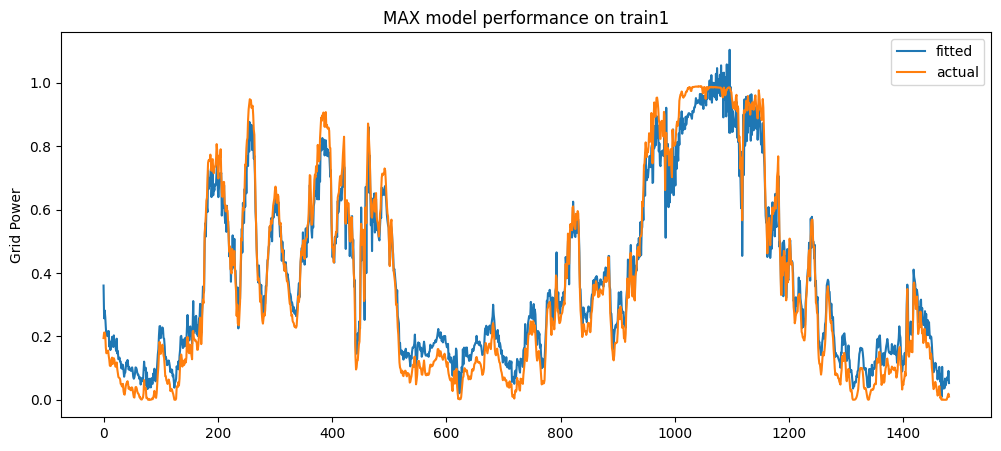

In [7]:
# Performance on train1 itself
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
plt.plot(res.fittedvalues, label="fitted")
plt.plot(train1[:,0], label="actual")
plt.legend(loc='upper right')
plt.title("MAX model performance on train1")
plt.ylabel("Grid Power")
plt.savefig(fname="ORIGtrain1.png")

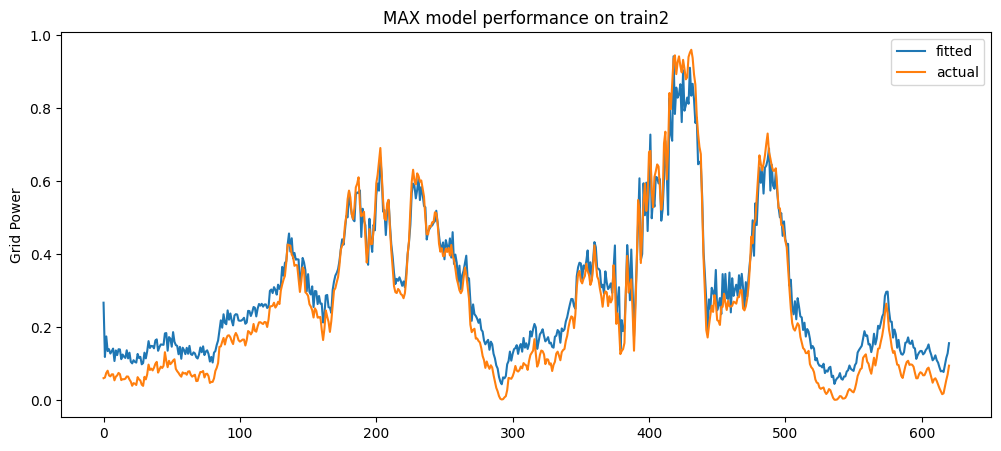

In [8]:
# Performance on train2 with the same parameters
res2 = res.apply(endog=train2[:,0],exog=train2[:,1])
fig = plt.figure(figsize=(12, 5))
plt.plot(res2.fittedvalues, label="fitted")
plt.plot(train2[:,0], label="actual")
plt.legend(loc='upper right')
plt.title("MAX model performance on train2")
plt.ylabel("Grid Power")
plt.savefig(fname="ORIGtrain2.png")

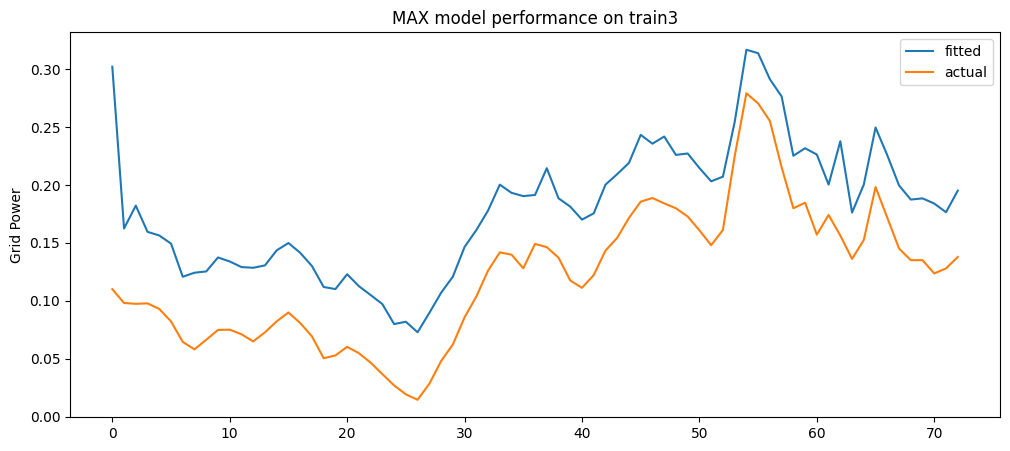

In [9]:
# Performance on train3 with the same parameters
res3 = res.apply(endog=train3[:,0],exog=train3[:,1])
fig = plt.figure(figsize=(12, 5))
plt.plot(res3.fittedvalues, label="fitted")
plt.plot(train3[:,0], label="actual")
plt.legend(loc='upper right')
plt.title("MAX model performance on train3")
plt.ylabel("Grid Power")
plt.savefig(fname="ORIGtrain3.png")

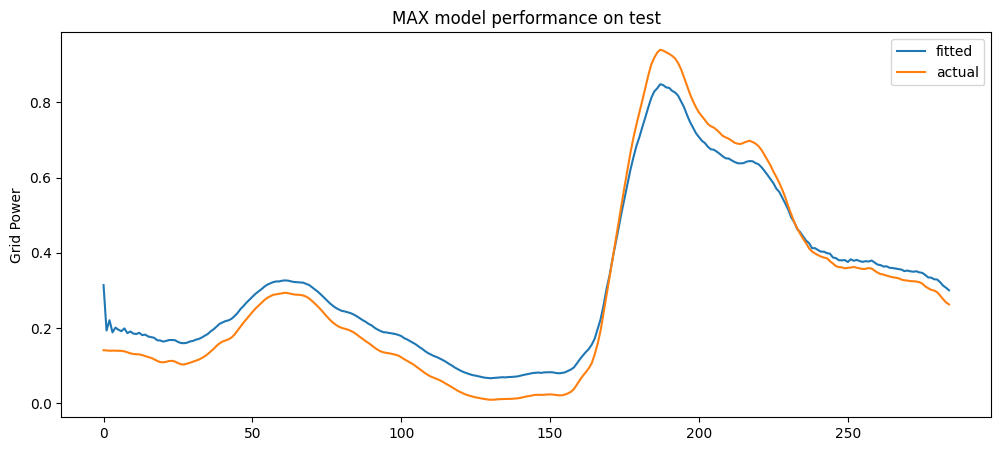

In [13]:
# Performance on test with the same parameters
res4 = res.apply(endog=test[:,0],exog=test[:,1])
fig = plt.figure(figsize=(12, 5))
plt.plot(res4.fittedvalues, label="fitted")
plt.plot(test[:,0], label="actual")
plt.legend(loc='upper right')
plt.title("MAX model performance on test")
plt.ylabel("Grid Power")
plt.savefig(fname="ORIGtest.png")

In [29]:
# Divide test into 5 parts and Evaluate
res1 = res.apply(endog=test[:45,0],exog=test[:45,1])
fore1 = res1.forecast(12,exog=test[45:57,1])
re = fore1 - test[45:57,0]
res2 = res.apply(endog=test[57:102,0],exog=test[57:102,1])
fore2 = res2.forecast(12,exog=test[102:114,1])
re_tmp = fore2 - test[102:114,0]
re = np.concatenate((re,re_tmp))
res3 = res.apply(endog=test[114:159,0],exog=test[114:159,1])
fore3 = res3.forecast(12,exog=test[159:171,1])
re_tmp = fore3 - test[159:171,0]
re = np.concatenate((re,re_tmp))
res4 = res.apply(endog=test[171:216,0],exog=test[171:216,1])
fore4 = res4.forecast(12,exog=test[216:228,1])
re_tmp = fore4 - test[216:228,0]
re = np.concatenate((re,re_tmp))
res5 = res.apply(endog=test[228:273,0],exog=test[228:273,1])
fore5 = res5.forecast(12,exog=test[273:285,1])
re_tmp = fore5 - test[273:285,0]
re = np.concatenate((re,re_tmp))
re = np.abs(re)
print(np.mean(re))
print(np.max(re))
print(np.median(re))
print(np.sqrt(1/60*np.sum(re**2)))
idx = abs(re) <= 0.15
print(sum(idx)/60)

0.13029023030628722
0.19139133686518017
0.13043682423341696
0.1372607889110171
0.6666666666666666


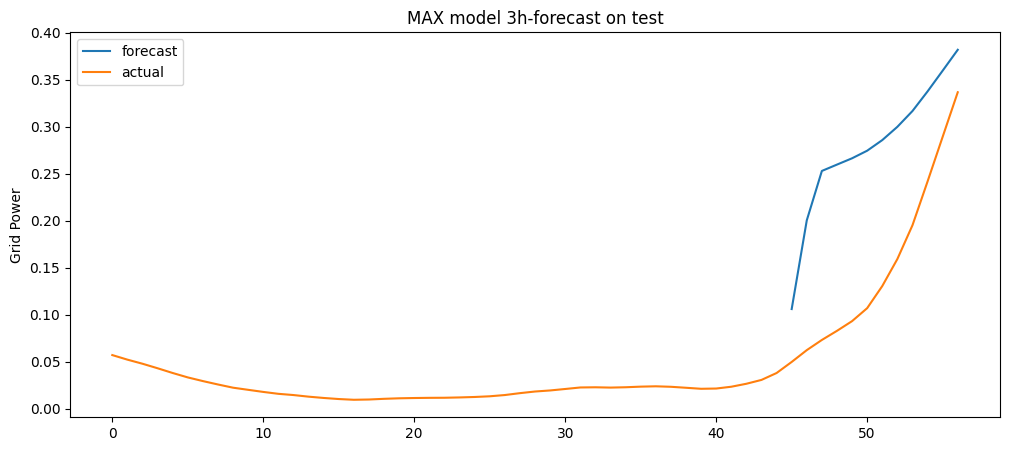

In [28]:
# Forecast Example (12 terms)
fig = plt.figure(figsize=(12, 5))
plt.plot(range(45,57),fore3, label="forecast")
plt.plot(test[114:171,0], label="actual")
plt.legend(loc='upper left')
plt.title("MAX model 3h-forecast on test")
plt.ylabel("Grid Power")
plt.savefig(fname="ORIGforecast.png")

# Now using another approach xgboost to predict the data

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
from sklearn.multioutput import MultiOutputRegressor

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
def create_datasets(df,Y,seq_length,output_size):
    dataX, dataY = [],[]
    for idx in range(len(df)-seq_length):
        a = np.hstack((df[idx:(idx+seq_length-output_size),0],df[idx:(idx+seq_length-output_size),1]))
        # a = df[idx:(idx+seq_length-output_size),0]
        b = Y[(idx+seq_length-output_size):(idx+seq_length)]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX),np.array(dataY)

In [7]:
# Training Sets
train1 = np.array(wind1[["GridPowerMA","WindSpdMA"]][19:])
train_X1, train_Y1 = create_datasets(train1,np.array(wind1["GridPowerMA"][19:]),sequence_length,output_size)
train2 = np.array(wind2[["GridPowerMA","WindSpdMA"]][19:])
train_X2, train_Y2 = create_datasets(train2,np.array(wind2["GridPowerMA"][19:]),sequence_length,output_size)
train3 = np.array(wind3[["GridPowerMA","WindSpdMA"]][19:])
train_X3, train_Y3 = create_datasets(train3,np.array(wind3["GridPowerMA"][19:]),sequence_length,output_size)
trainX = np.concatenate((train_X1,train_X2,train_X3),axis=0)
trainY = np.concatenate((train_Y1,train_Y2,train_Y3),axis=0)

# Test Sets
test = np.array(wind4[["GridPowerMA","WindSpdMA"]][19:])
test_target = np.array(wind4["GridPowerMA"][19:])
test_X, test_Y = create_datasets(test,test_target,sequence_length,output_size)
test_target1 = np.array(wind4["GridPower"][19:])
test_X, test_Y1 = create_datasets(test,test_target1,sequence_length,output_size)

In [8]:
model_xgb1 = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror",n_estimators=30,max_depth=5))
model_xgb1.fit(trainX,trainY)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=30, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None))

In [9]:
# for ma data
output_predict = model_xgb1.predict(test_X)
test_mse = MSE(test_Y,output_predict)
print("MSE=",test_mse)
re = np.abs(test_Y-output_predict).reshape(-1,)
idx = re <= 0.15
idx = idx+0
print("Q=",sum(idx)/len(idx))

MSE= 0.0009377445225091498
Q= 0.9929718875502008


In [10]:
# for no ma data
output_predict = model_xgb1.predict(test_X)
test_mse = MSE(test_Y1,output_predict)
print("MSE=",test_mse)
re = np.abs(test_Y1-output_predict).reshape(-1,)
idx = re <= 0.15
idx = idx+0
print("Q=",sum(idx)/len(idx))

MSE= 0.027461372977194764
Q= 0.822289156626506


In [11]:
# Training Sets
train1 = np.array(wind1[["GridPower","WindSpd"]][19:])
train_X1, train_Y1 = create_datasets(train1,np.array(wind1["GridPower"][19:]),sequence_length,output_size)
train2 = np.array(wind2[["GridPower","WindSpd"]][19:])
train_X2, train_Y2 = create_datasets(train2,np.array(wind2["GridPower"][19:]),sequence_length,output_size)
train3 = np.array(wind3[["GridPower","WindSpd"]][19:])
train_X3, train_Y3 = create_datasets(train3,np.array(wind3["GridPower"][19:]),sequence_length,output_size)
trainX = np.concatenate((train_X1,train_X2,train_X3),axis=0)
trainY = np.concatenate((train_Y1,train_Y2,train_Y3),axis=0)

# Test Sets
test = np.array(wind4[["GridPower","WindSpd"]][19:])
test_target = np.array(wind4["GridPower"][19:])
test_X, test_Y = create_datasets(test,test_target,sequence_length,output_size)

In [12]:
model_xgb2 = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror",n_estimators=30,max_depth=5))
model_xgb2.fit(trainX,trainY)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=30, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None))

In [13]:
# for no ma data
output_predict = model_xgb2.predict(test_X)
test_mse = MSE(test_Y,output_predict)
print("MSE =",test_mse)
re = np.abs(test_Y-output_predict).reshape(-1,)
idx = re <= 0.15
idx = idx+0
print("Q =",sum(idx)/len(idx))

MSE = 0.006675625729542462
Q = 0.9397590361445783


In [14]:
# for no ma data
output_predict = model_xgb1.predict(test_X)
test_mse = MSE(test_Y1,output_predict)
print("MSE=",test_mse)
re = np.abs(test_Y1-output_predict).reshape(-1,)
idx = re <= 0.15
idx = idx+0
print("Q=",sum(idx)/len(idx))

MSE= 0.004815284580940926
Q= 0.9578313253012049


In [ ]:
re = np.abs(test_Y-output_predict)
re = np.sum(re,axis=1)
order = np.argsort(re)

## plot data preparation
x1 = test_X[order[0],0:32]
y1 = test_Y[order[0],:]
pre1 = output_predict[order[0],:]
lo1 = np.hstack((x1,y1))
lp1 = np.hstack((x1,pre1))

x2 = test_X[order[1],0:32]
y2 = test_Y[order[1],:]
pre2 = output_predict[order[1],:]
lo2 = np.hstack((x2,y2))
lp2 = np.hstack((x2,pre2))

x3 = test_X[order[2],0:32]
y3 = test_Y[order[2],:]
pre3 = output_predict[order[2],:]
lo3 = np.hstack((x3,y3))
lp3 = np.hstack((x3,pre3))

x4 = test_X[order[3],0:32]
y4 = test_Y[order[3],:]
pre4 = output_predict[order[3],:]
lo4 = np.hstack((x4,y4))
lp4 = np.hstack((x4,pre4))

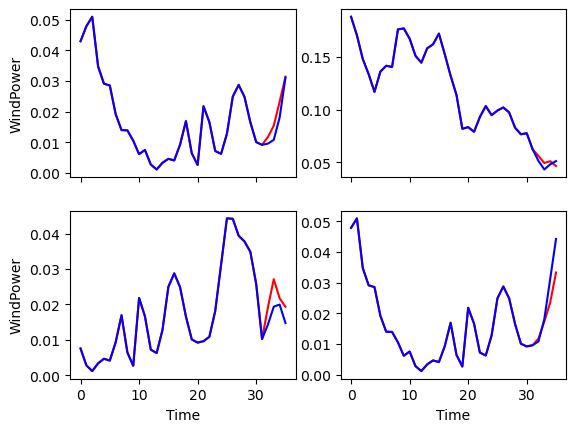

In [ ]:
# 红色为fitted data，蓝色为original data
import matplotlib.pyplot as plt
plt.subplots(2,2,sharex=True)

plt.subplot(2,2,1)
plt.plot(lp1,"r")
plt.plot(lo1,"b")
plt.ylabel("WindPower")

plt.subplot(2,2,2)
plt.plot(lp2,"r")
plt.plot(lo2,"b")

plt.subplot(2,2,3)
plt.plot(lp3,"r")
plt.plot(lo3,"b")
plt.ylabel("WindPower")
plt.xlabel("Time")

plt.subplot(2,2,4)
plt.plot(lp4,"r")
plt.plot(lo4,"b")
plt.xlabel("Time")

plt.show()